In [26]:
import pandas as pd

BASE = "/mnt/e/bootcamp/Project/azmmon_farz"

utm   = pd.read_csv(f"{BASE}/utm_coords1.csv")                  # ['UTM_Easting','UTM_Northing']
price = pd.read_csv(f"{BASE}/total_price.csv", low_memory=False) # ['Unnamed: 0','total_price']

price = price.drop(columns=["Unnamed: 0"])       # حذف ستون اضافی
df = utm.copy()
df["price"] = price["total_price"]               # چسباندن قیمت‌ها به همان ترتیب
df.head()


,UTM_Easting,UTM_Northing,price
0,4.942723e+05,3.963064e+06,1.600325e+12
1,5.399785e+05,3.958870e+06,8.500000e+09
2,5.337844e+05,3.951168e+06,8.083333e+09
3,5.384862e+05,3.960125e+06,2.058333e+10
4,1.271575e+06,4.047854e+06,5.750000e+09


In [27]:
from sklearn.cluster import KMeans

X = df[["UTM_Easting", "UTM_Northing"]].values
kmeans = KMeans(n_clusters=10, random_state=42, n_init=30)
df["cluster"] = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_


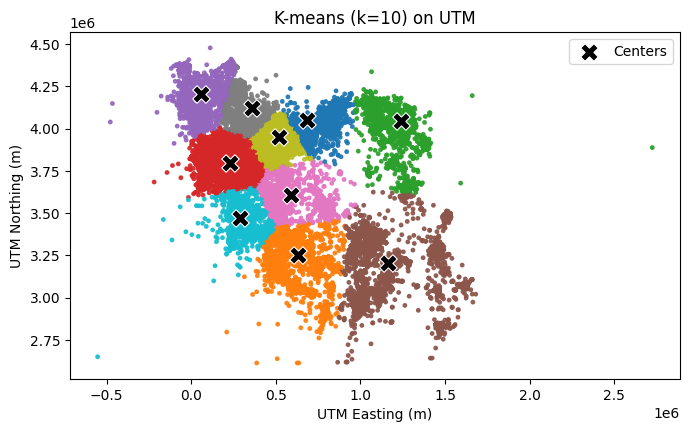

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(df["UTM_Easting"], df["UTM_Northing"],
            c=df["cluster"], cmap="tab10", s=6, alpha=0.9)
plt.scatter(centers[:,0], centers[:,1], marker="X", s=160,
            c="black", edgecolors="white", linewidths=0.8, label="Centers")
plt.gca().set_aspect("equal", "box")
plt.xlabel("UTM Easting (m)"); plt.ylabel("UTM Northing (m)")
plt.title("K-means (k=10) on UTM"); plt.legend(); plt.tight_layout(); plt.show()


In [29]:
import numpy as np

# صدک‌های 1% و 99% (می‌تونی تغییر بدی مثلاً 5% و 95%)
q1, q99 = df["price"].quantile([0.01, 0.99])

# برش قیمت روی این بازه
df["price_clip"] = df["price"].clip(lower=q1, upper=q99)

# لگاریتم قیمت (برای نمایش بهتر)
df["price_log"] = np.log1p(df["price_clip"])

mask = df["price_log"].notna()   # برای رسم، NaN ها نمایش داده نشن
q1, q99


(651814.8200000003, 75000000000.0)

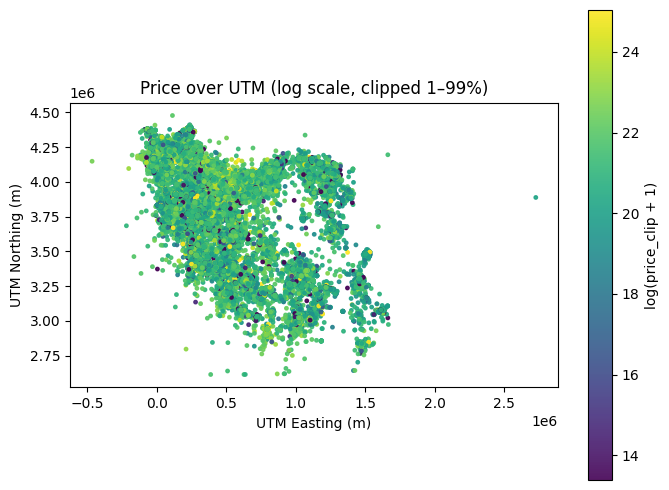

In [30]:
plt.figure(figsize=(7,5))
plt.scatter(df.loc[mask, "UTM_Easting"],
            df.loc[mask, "UTM_Northing"],
            c=df.loc[mask, "price_log"], cmap="viridis", s=6, alpha=0.9)
plt.colorbar(label="log(price_clip + 1)")
plt.gca().set_aspect("equal", "box")
plt.xlabel("UTM Easting (m)"); plt.ylabel("UTM Northing (m)")
plt.title("Price over UTM (log scale, clipped 1–99%)")
plt.tight_layout(); plt.show()


# section 2

In [31]:
import numpy as np

X = df[["UTM_Easting", "UTM_Northing"]].values
X.shape


(1000000, 2)

In [32]:
from sklearn.cluster import KMeans

k_values = list(range(1, 21))
wcss = []

# (اختیاری) نمونه‌گیری برای سرعت بیشتر: sample_n = 200_000  یا None
sample_n = None
X_used = X if (sample_n is None or len(X) <= sample_n) else X[np.random.RandomState(42).choice(len(X), sample_n, replace=False)]

for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_used)
    wcss.append(km.inertia_)   # WCSS
wcss[:5], len(wcss)


([1.8129251505047664e+17,
  1.0497934637511656e+17,
  5.8827376054293384e+16,
  4.2756293257152344e+16,
  2.771234645919723e+16],
 20)

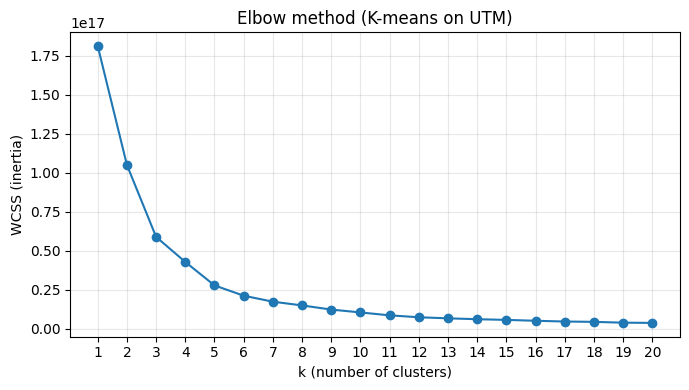

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(k_values, wcss, marker="o")
plt.xticks(k_values)
plt.xlabel("k (number of clusters)")
plt.ylabel("WCSS (inertia)")
plt.title("Elbow method (K-means on UTM)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [34]:
import numpy as np

wcss_arr = np.array(wcss, dtype=float)
improve = (wcss_arr[:-1] - wcss_arr[1:]) / wcss_arr[:-1]  # بهبود نسبی از k به k+1

threshold = 0.10  # 10% آستانه
candidates = np.where(improve < threshold)[0]
best_k = (candidates[0] + 1) if len(candidates) > 0 else int(np.argmin(np.diff(wcss_arr,2)) + 2)

print("Relative improvements per step:", np.round(improve, 3))
print("Suggested k =", best_k)


Relative improvements per step: [0.421 0.44  0.273 0.352 0.239 0.182 0.139 0.18  0.15  0.181 0.144 0.095
 0.085 0.074 0.101 0.097 0.046 0.123 0.035]
Suggested k = 12


In [35]:
final_k = best_k  # اگر خواستی دستی تغییر بده
kmeans_final = KMeans(n_clusters=final_k, n_init=30, random_state=42)
df["cluster_kbest"] = kmeans_final.fit_predict(X)
centers_kbest = kmeans_final.cluster_centers_

# آمار ساده از هر خوشه
counts = df["cluster_kbest"].value_counts().sort_index()
print("Cluster counts:\n", counts)
centers_kbest


Cluster counts:
 cluster_kbest
0      65159
1      81112
2      92849
3      78834
4     399998
5      53965
6      20478
7      13175
8      69588
9      59872
10     41478
11     23492
Name: count, dtype: int64


array([[ 616429.09827094, 3274750.28458291],
       [ 358403.08272571, 4119188.38119412],
       [1240527.39216243, 4056237.87485326],
       [ 227342.87728587, 3796186.32737802],
       [ 521307.03469764, 3949757.38256142],
       [  56819.76489886, 4203806.67848687],
       [ 967907.56171149, 3004705.75112966],
       [1472390.02697587, 3224939.57319999],
       [ 590901.55321951, 3606968.8409742 ],
       [ 684849.95997346, 4048472.90340009],
       [ 289349.89360482, 3473230.71621037],
       [1088713.01907641, 3377907.15161362]])

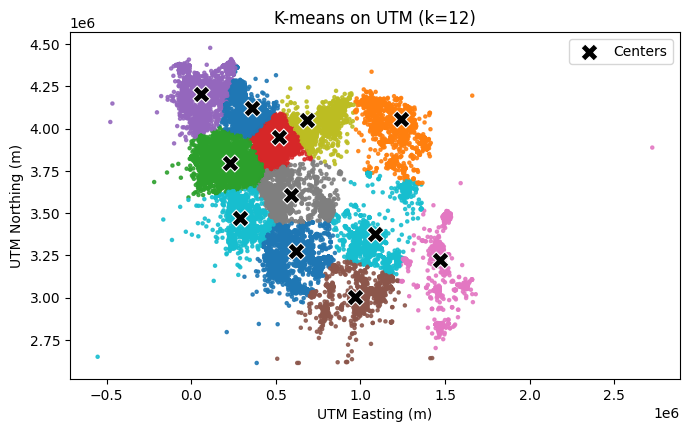

In [36]:
plt.figure(figsize=(7,5))
plt.scatter(df["UTM_Easting"], df["UTM_Northing"],
            c=df["cluster_kbest"], cmap="tab10", s=5, alpha=0.85)
plt.scatter(centers_kbest[:,0], centers_kbest[:,1], marker="X", s=150,
            c="black", edgecolors="white", linewidths=0.8, label="Centers")
plt.gca().set_aspect("equal", "box")
plt.xlabel("UTM Easting (m)"); plt.ylabel("UTM Northing (m)")
plt.title(f"K-means on UTM (k={final_k})")
plt.legend(); plt.tight_layout(); plt.show()


# section 3